# **Year 3 project - Optimising the stability of a catalyst**

**Data Loading + imports**

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matminer.featurizers.conversions import StrToComposition
initial_df = pd.read_csv(r'C:\Users\Fahim\Yr3-Project-1\Python import.csv')

**Data exploration**

In [54]:
#print(initial_df.head())
#print(initial_df.columns)
#print(initial_df.describe())
#print(initial_df.info())

**Data cleaning**

In [55]:
#This function will replace '-' values for zeroes. Also replace Nan values with zeroes
def parse_Nan(dataset):
    parse_datatset = dataset.replace('-',0) 
    parse_datatset = parse_datatset.fillna(0)
    return parse_datatset

In [56]:
#filter columns that are required for us. Also convert some object columns to floats
def column_cleaning(dataset):
    columns_to_keep = ["Catalyst Materials","Family","ΔGOH*","ΔGO*","ΔGOOH*","Overpotential at xx (nearby) current density vs RHE, V"]
    entropy_data = dataset.loc[:,columns_to_keep]
    columns_to_int = ["ΔGOH*","ΔGO*","ΔGOOH*","Overpotential at xx (nearby) current density vs RHE, V"]
    entropy_data[columns_to_int] = entropy_data[columns_to_int].astype(float)
    return entropy_data

In [57]:
#Launching functions
initial_df = parse_Nan(initial_df)
entropy_data = column_cleaning(initial_df)
entropy_data['ΔGO*-ΔGOH*'] = entropy_data['ΔGO*'] - entropy_data['ΔGOH*']
entropy_data['ΔGOOH*-ΔGOH*'] = entropy_data['ΔGOOH*'] - entropy_data['ΔGOH*']

#print(entropy_data.describe())

**Preparing first graph**

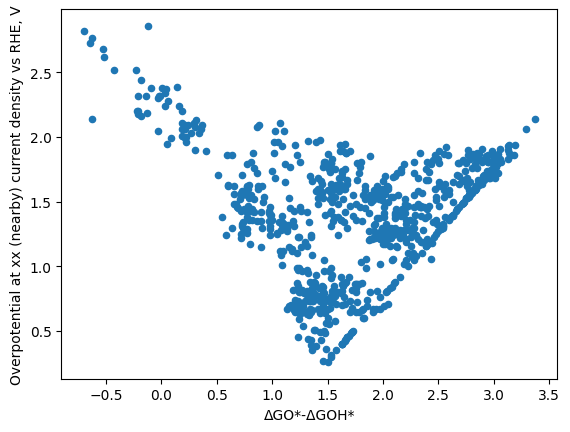

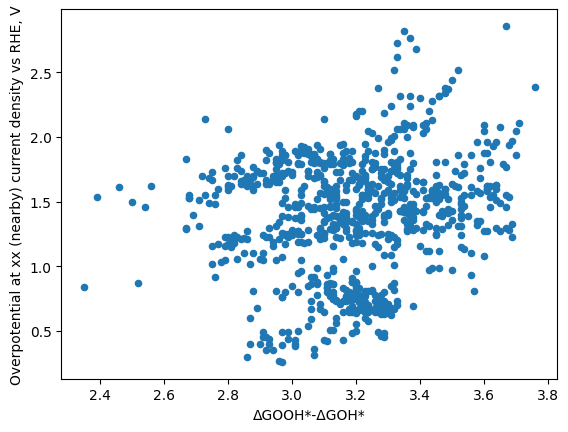

In [58]:
#Slicing only data with values for required columns, then plotting dataset
entropy_data = entropy_data.loc[entropy_data["ΔGO*-ΔGOH*"] != 0.0 ]
entropy_data = entropy_data.loc[entropy_data["ΔGOOH*-ΔGOH*"] != 0.0 ]
entropy_data.plot(x='ΔGO*-ΔGOH*', y = 'Overpotential at xx (nearby) current density vs RHE, V', kind='scatter')
plt.show()
entropy_data.plot(x='ΔGOOH*-ΔGOH*', y = 'Overpotential at xx (nearby) current density vs RHE, V', kind='scatter')
plt.show()

**Clustering**

In [59]:
#Creating an elbow plot to determine how many cluster will be required for model
def elbow_plot(elbow_data):
    k_rng = range(1,10)
    sse = []
    for k in k_rng:
        km = KMeans(n_clusters= k)
        km.fit(elbow_data[['ΔGO*-ΔGOH*','Overpotential at xx (nearby) current density vs RHE, V']])
        sse.append(km.inertia_)
    plt.xlabel('k')
    plt.ylabel('Sum of squared error')
    plt.plot(k_rng,sse)
    plt.show()

In [60]:
#Creating cluster plot using K-means method
def cluster_df(cluster_df,n_clusters):
    color = ['black','green','purple','red','blue']
    for k in range(0,n_clusters):
        data = cluster_df[cluster_df["cluster"]==k]
        plt.scatter(data['ΔGO*-ΔGOH*'],data["Overpotential at xx (nearby) current density vs RHE, V"],c=color[k])
        print(data['Overpotential at xx (nearby) current density vs RHE, V'].max())
    

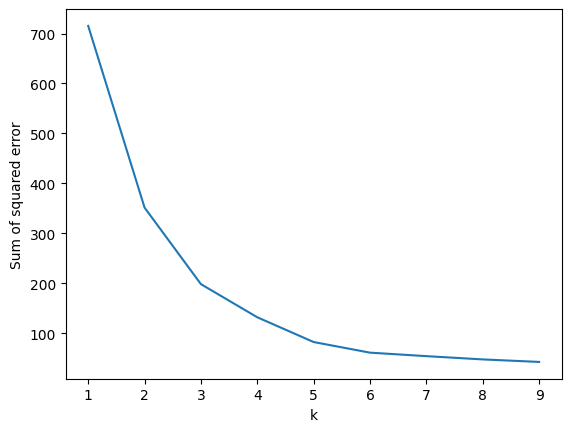

1.09
2.11
1.89
2.86
2.14


Text(0, 0.5, 'Overpotential at xx (nearby) current density vs RHE, V')

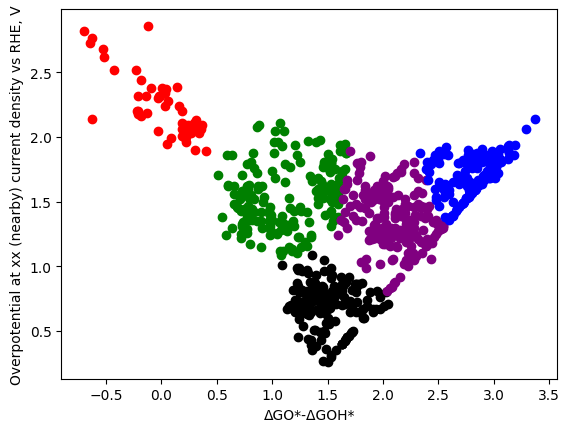

In [61]:
#Placing functions down
elbow_plot(entropy_data)
km = KMeans(n_clusters= 5)
y_predicted = km.fit_predict(entropy_data[['ΔGO*-ΔGOH*','Overpotential at xx (nearby) current density vs RHE, V']])
entropy_data['cluster'] = y_predicted
cluster_df(entropy_data,5)
plt.xlabel('ΔGO*-ΔGOH*')
plt.ylabel('Overpotential at xx (nearby) current density vs RHE, V')

**Data exploration of optimum cluster**

In [62]:
#Function to determine proprtion of different catalyst materials in each dataset
def printing_stats_1(df_1,df_2,df_3):
    df_names = ['optimum catalysts','filtered initial','initial']
    data = [df_1, df_2 ,df_3] 
    for i in range(0,3):
        print('The number of families in the', df_names[i], 'dataframe + normalized is:')
        print(data[i]['Family'].value_counts())
        print(data[i]['Family'].value_counts(normalize= True))

In [63]:
#Summary statistics on family data on optimum catalysts, catalyst filtered down to our data and the whole initial DF
optimum_catalyst = entropy_data[entropy_data['Overpotential at xx (nearby) current density vs RHE, V']<1.10]
printing_stats_1(optimum_catalyst,entropy_data,initial_df)

The number of families in the optimum catalysts dataframe + normalized is:
Perovskite          176
Bimetallic oxide     26
Name: Family, dtype: int64
Perovskite          0.871287
Bimetallic oxide    0.128713
Name: Family, dtype: float64
The number of families in the filtered initial dataframe + normalized is:
Perovskite          805
Bimetallic oxide     26
Name: Family, dtype: int64
Perovskite          0.968712
Bimetallic oxide    0.031288
Name: Family, dtype: float64
The number of families in the initial dataframe + normalized is:
Perovskite                                     826
0                                               48
Bimetallic oxide                                26
Noble metal                                     23
Transition metal dichalcogenide                 18
Noble metal oxide                               16
2D TMD, 2H                                       9
2D TMD, 1T                                       7
Transition metal phosphide                       4
Tra

**Element composition featurisation**

In [64]:
#Creating a column for element composition
str_comp = StrToComposition(target_col_id='composition')
entropy_data = str_comp.featurize_dataframe(entropy_data, col_id='Catalyst Materials')
#print(entropy_data)

StrToComposition: 100%|██████████| 831/831 [00:30<00:00, 27.57it/s] 


In [65]:
print(entropy_data.head())

  Catalyst Materials      Family  ΔGOH*  ΔGO*  ΔGOOH*  \
3             AgAlO3  Perovskite   2.18  4.63    5.10   
4             AgBiO3  Perovskite   1.09  3.37    4.23   
7             AgCoO3  Perovskite   1.59  3.28    4.66   
8             AgCrO3  Perovskite   0.83  2.36    4.26   
9             AgCuO3  Perovskite   1.80  4.36    4.79   

   Overpotential at xx (nearby) current density vs RHE, V  ΔGO*-ΔGOH*  \
3                                               1.82             2.45   
4                                               1.55             2.28   
7                                               0.92             1.69   
8                                               1.31             1.53   
9                                               1.38             2.56   

   ΔGOOH*-ΔGOH*  cluster  composition  
3          2.92        4  (Ag, Al, O)  
4          3.14        2  (Ag, Bi, O)  
7          3.07        0  (Ag, Co, O)  
8          3.43        1  (Ag, Cr, O)  
9          2.99   